# Influencers in Social Networks
Albert Byun, Hussein Danish, Nick Hamlin, Vincent Chio, Walter Erquinigo Pezo

## Background 

See https://www.kaggle.com/c/predict-who-is-more-influential-in-a-social-network/data for more info on the problem setup. An example solution is available at https://gist.github.com/fhuszar/5372873

In [1]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

## Data Ingest

In [2]:
def load_train_data():
    with open('data/train.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        data = np.loadtxt(f, delimiter=',')
        X, Y = data[:,1:], data[:,:1]
        return features, X, Y.flatten()

def load_test_data():
    with open('data/test.csv') as f:
        features = f.next().rstrip().split(',')[1:]
        return np.loadtxt(f, delimiter=',')

def prepare_train_data(X, Y, test_size=1.0/2):
    np.random.seed(0)
    
    shuffle = np.random.permutation(np.arange(X.shape[0]))
    X, Y = X[shuffle], Y[shuffle]
    break_point = int(X.shape[0] * (1 - test_size))
    return X[:break_point], Y[:break_point], X[break_point:], Y[break_point:]


features, X, Y = load_train_data()
train_data, train_labels, dev_data, dev_labels = prepare_train_data(X, Y)
test_data = load_test_data()

train_data = np.array(train_data)
dev_data = np.array(train_data)
test_data = np.array(test_data)

print train_data.shape, dev_data.shape, test_data.shape

(2750, 22) (2750, 22) (5952, 22)


In [3]:
def transform_features(x):
    return np.log(1+x)

def subtract(x):
    return np.array([xx[0:11] - xx[11:] for xx in x])

## KNN

In [4]:
def knn(x_train, y_train, x_test, y_test):
    kn = KNeighborsClassifier(n_neighbors=10)
    kn.fit(x_train, y_train)
    return kn.score(x_test, y_test)

print knn(
    subtract(transform_features(dev_data)), 
    dev_labels, 
    subtract(transform_features(train_data)),
    train_labels)
print knn(
    subtract(dev_data), 
    dev_labels, 
    subtract(train_data),
    train_labels)

0.485090909091
0.494181818182


In [4]:
from sklearn import linear_model
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.decomposition import PCA
from sklearn.decomposition import SparsePCA
from sklearn.ensemble import BaggingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.cross_validation import cross_val_score
#from sklearn.ensemble import VotingClassifier
    
def trans(x):
    A = x[:,:11]
    B = x[:,11:]
    
    AA = np.log(1 + A)
    BB = np.log(1 + B)

    return AA - BB

def logistic(x_train, y_train, x_test, y_test,c):
    clf = logistic = linear_model.LogisticRegression(C=c)
    clf.fit(x_train, y_train)
    return clf.score(x_test, y_test)

def logistic2(x_train, y_train, x_test, y_test,c):
    
    clf1 = LogisticRegression(C=c)
    clf2 = RandomForestClassifier()
    clf3 = GaussianNB()
    clf4 = KNeighborsClassifier(n_neighbors=30, weights='distance')
    clf5 = BaggingClassifier(LogisticRegression(C=1/.60),max_samples=0.8, max_features=0.7)
    x = x_test + x_train
    
    for clf, label in zip([clf1, clf2, clf3, clf4, clf5], ['Logistic Regression', 'Random Forest', 'naive Bayes', 'knn', 'bagging']):
        scores = cross_val_score(
            clf, 
            x[:, (0, 2, 3, 4, 9)], 
            y_test + y_train, 
            cv=10, 
            scoring='accuracy')
        print("Accuracy: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

    return 0
'''
print logistic(
    subtract(transform_features(dev_data))[:,:5], 
    dev_labels, 
    subtract(transform_features(train_data))[:,:5],
    train_labels,
    1/60.)
'''
print logistic2(
    trans(dev_data), 
    dev_labels, 
    trans(train_data),
    train_labels,
    1/60.)

Accuracy: 0.49 (+/- 0.03) [Logistic Regression]
Accuracy: 0.45 (+/- 0.02) [Random Forest]
Accuracy: 0.44 (+/- 0.02) [naive Bayes]
Accuracy: 0.48 (+/- 0.02) [knn]
Accuracy: 0.49 (+/- 0.02) [bagging]
0


[ 0.78764603  0.13564074  0.05399839]
[[ 0.55316071  0.12228248  0.47610045  0.49672587  0.45348869]
 [-0.09205973 -0.9375624  -0.09770293  0.19284073  0.25645337]
 [ 0.47339451 -0.32347481  0.47381104 -0.45288181 -0.49159214]]


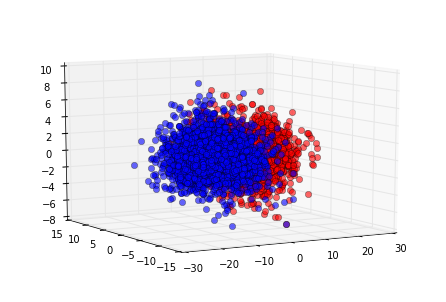

In [120]:
from mpl_toolkits.mplot3d import Axes3D
def plot():
    pca = PCA(n_components=3)
    x = pca.fit_transform(trans(X)[:,:5])
    reds = Y == 1.
    blues = Y == 0.
    
    fig = plt.figure()
    ax = Axes3D(fig)
    print pca.explained_variance_ratio_ 
    print pca.components_
    ax.view_init(elev=10., azim=240)
    ax.plot(x[reds, 0], x[reds, 1], x[reds, 2], "ro", alpha=0.6)
    ax.plot(x[blues, 0], x[blues, 1], x[blues, 2], "bo", alpha=0.6)

plot()

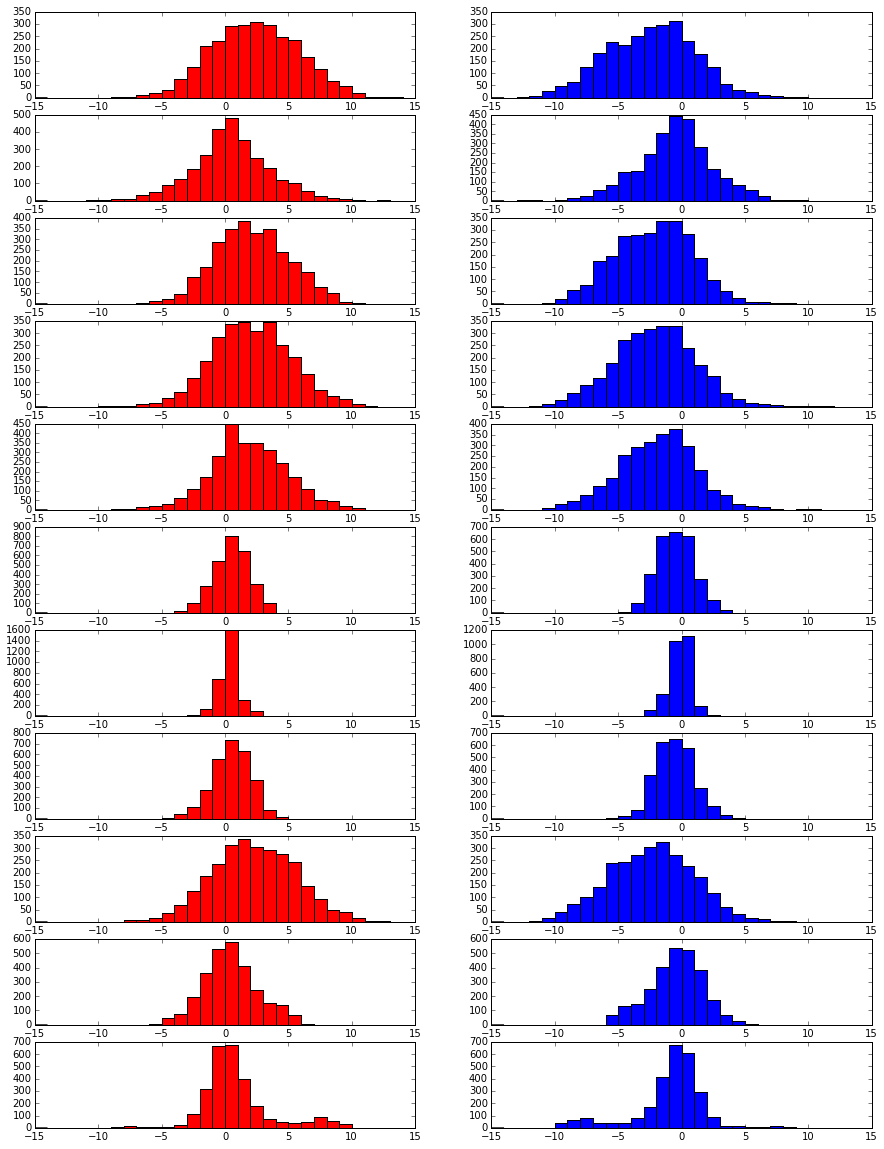

In [161]:
def p():
    reds = Y == 1.
    blues = Y == 0.
    x = trans(X)
    tot = 0
    plt.figure(figsize=(15, 20))
    for i in range(11):
        plt.subplot(11, 2, tot + 1)
        plt.hist(x[reds, i], bins=30, range=(-15, 15), color="red")
        
        plt.subplot(11, 2, tot + 2)
        plt.hist(x[blues, i], bins=30, range=(-15, 15))
        tot += 2
p()

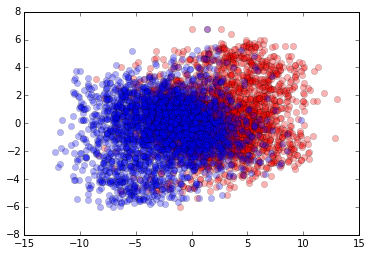

In [168]:
def p2():
    x = trans(X)
    reds = Y == 1.
    blues = Y == 0.
 
    plt.plot(x[reds, 0], x[reds, 9], "ro", alpha=0.3)
    plt.plot(x[blues, 0], x[blues, 9], "bo", alpha=0.3)
    
p2()

## Export Results for Kaggle Submission

In [110]:
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')

pca = PCA(n_components=3)
x = pca.fit_transform(trans(X)**3)
test_x = pca.transform(trans(test_data)**3)

clf = LogisticRegression(C=1/60.)
clf.fit(x, Y)
proba = clf.predict_proba(test_x)
    
generate_test_output(proba)

In [266]:
from sklearn import svm
#
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')


x = trans(X)
u = np.mean(x)
s = np.std(x)

pca = PCA(n_components=11)
x = pca.fit_transform((x - u) / s)
test_x = pca.transform((trans(test_data) - u) / s)

clfs = [
    #KNeighborsClassifier(n_neighbors=100, weights='distance'), 
    #LogisticRegression(C=1/60.), 
    #GaussianNB(),
    #RandomForestClassifier(),
    svm.SVC(probability=True)
]
for c in clfs:
    c.fit(x, Y)

probs = np.array([c.predict_proba(x)[:, 0] for c in clfs]).T
clf = LogisticRegression()
clf.fit(probs, Y)

probs2 = np.array([c.predict_proba(x)[:, 0] for c in clfs]).T
print clf.score(probs2, Y)

probs2 = np.array([c.predict_proba(test_x)[:, 0] for c in clfs]).T
generate_test_output(clf.predict_proba(probs2))

0.773454545455


In [267]:

#0.86099
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(prob[1])+'\n')


x = subtract(transform_features(X))#[:,(0, 2, 3, 4, 9)]
test_x = subtract(transform_features(test_data))#[:,(0, 2, 3, 4, 9)]
u = np.mean(x)
s = np.std(x)
clf = linear_model.LogisticRegression(fit_intercept=True, C=1/.60)
#clf = KNeighborsClassifier(n_neighbors=20)
clf.fit((x - u) / s, Y)
proba = clf.predict_proba((test_x - u) / s)
    
generate_test_output(proba)

In [6]:
#0.86104
def generate_test_output(pred_probs):
    with open("test_labeled.csv", "w") as f:
        f.write('Id,Choice\n')
        for i,prob in enumerate(pred_probs):
            f.write(str(i+1)+','+str(0.6 if prob[1] == 0.5 else prob[1])+'\n')


x = subtract(transform_features(X))
test_x = subtract(transform_features(test_data))
u = np.mean(x)
s = np.std(x)
clf = bagging = BaggingClassifier(
    LogisticRegression(C=1/.60),
    max_samples=0.3, max_features=0.7, n_estimators=200, n_jobs=-1, random_state=1)
clf.fit((x - u) / s, Y)
proba = clf.predict_proba((test_x - u) / s)
    
generate_test_output(proba)